In [1]:
import pandas

data = pandas.read_csv("./age_gender.csv")

In [2]:
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


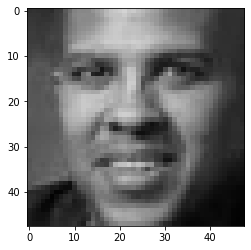

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import math

image = data['pixels'][15000].split(' ')
image = [int(x) for x in image]
image = np.array(image)

size = int(math.sqrt(len(data['pixels'][1].split(' '))))

image = np.resize(image, (size, size))

plt.imshow(image, cmap='gray', vmin=0, vmax=255)

In [4]:
import os
from matplotlib import pyplot as plt
import numpy as np
import math
from PIL import Image
from tqdm import tqdm


def filter(dataDF):
    result = dataDF[dataDF['age'] > 20][dataDF['age'] < 60]
    result = result.reset_index()
    return result

def dumpImages(dataDF, path):
    os.system('rm -rf {}'.format(path))

    dataDF = dataDF.reset_index()

    numberOfImages = dataDF.shape[0]
    size = int(math.sqrt(len(dataDF['pixels'][0].split(' '))))
    os.mkdir(path)
    os.mkdir('{}/male'.format(path))
    os.mkdir('{}/female'.format(path))
    for i in tqdm(range(numberOfImages), desc='{} is dumping'.format(path)):
        image = dataDF['pixels'][i].split(' ')
        image = [int(x) for x in image]
        image = np.array(image).astype(np.uint8)

        image = np.resize(image, (size, size))

        image = Image.fromarray(image)
        if dataDF['gender'][i] == 0:
            image.save('{}/male/{}.jpeg'.format(path, i), 'JPEG')
        else:
            image.save('{}/female/{}.jpeg'.format(path, i), 'JPEG')


data = filter(data)
# dumpImages(data, './images')

In [5]:
data.head()

,index,age,ethnicity,gender,img_name,pixels
0,3452,21,0,0,20170116215442146.jpg.chip.jpg,5 5 5 5 6 8 6 6 6 4 6 16 50 85 109 127 133 139...
1,3453,21,0,0,20170116215444801.jpg.chip.jpg,86 84 50 58 56 56 58 56 63 94 197 234 242 242 ...
2,3454,21,0,0,20170116215656696.jpg.chip.jpg,4 5 6 6 6 6 4 4 5 5 3 3 4 5 7 7 11 30 52 51 84...
3,3455,21,0,0,20170116225141614.jpg.chip.jpg,54 53 52 51 49 52 60 67 74 81 87 91 94 104 109...
4,3456,21,0,0,20170117141432129.jpg.chip.jpg,82 95 111 126 135 141 142 148 152 156 159 161 ...


In [6]:
from sklearn.model_selection import train_test_split

def splitTrainTestVal(data, trainSize, testSize, randomState):
    if trainSize + testSize >= 1.0:
        return None
    valSize = 1.0 - trainSize - testSize

    dataTrainIndex, dataTestValIndex = train_test_split(data.index, train_size=trainSize, random_state=randomState)
    dataTestIndex, dataValIndex = train_test_split(dataTestValIndex, train_size=testSize / (testSize + valSize), random_state=randomState)

    return data.iloc[dataTrainIndex], data.iloc[dataTestIndex], data.iloc[dataValIndex]


train, test, val = splitTrainTestVal(data, 0.70, 0.2, 42)

# dumpImages(train, './train')
# dumpImages(test, './test')
# dumpImages(val, './val')

Text(0.5, 1.0, 'Class of image 0')

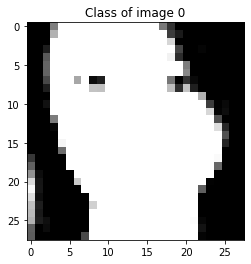

In [7]:
from torchvision import datasets, transforms
import torch
import numpy as np

def setTorchRandomState(randomState):
    torch.manual_seed(randomState)
    np.random.seed(randomState)
    torch.backends.cudnn.benchmark = False


def getDataLoader(path, transforms, batch_size, shuffle):
    trainDataset = datasets.ImageFolder(path, transform=transforms)
    trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

    return trainLoader


setTorchRandomState(224)

trainTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainDataLoader = getDataLoader('./train', transforms=trainTransforms, batch_size=32, shuffle=True)

valTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.1307,), (0.3081,))
])

valDataLoader = getDataLoader('./val', transforms=valTransforms, batch_size=32, shuffle=True)

inputs, classes = next(iter(trainDataLoader))
plt.imshow(inputs[0][0], cmap='gray', vmin=0, vmax=1)
plt.title('Class of image {}'.format(classes[0]))

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class GenderRecognitionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

    def predict(self, x):
        model.eval()
        output = self.forward(x)
        return F.sigmoid(output)

model = GenderRecognitionModel().cuda()

# inputs, classes = next(iter(trainDataLoader))
# inputs = inputs.cuda()
# output = model(inputs)
# print(output)
# print(classes)

In [9]:
from torch import optim
import torch

def lossBatch(model, inputs, classes, opt, lossFunc):
    opt.zero_grad()

    inputs = inputs.cuda()
    classes = classes.cuda()
    classes = classes.view(classes.shape[0], 1).to(torch.float32)
    
    outputs = model(inputs.to(torch.float32))
    loss = lossFunc(outputs, classes)

    results = torch.round(F.sigmoid(outputs))
    correct = (classes.eq(results.to(torch.float32))).sum()

    loss.backward()
    opt.step()

    return loss.item(), correct.item(), inputs.shape[0]

def train(model, trainDataLoader, valDataLoader, opt, lossFunc, epochs):
    for epoch in range(epochs):
        model.train()
        trainBatchLoss = 0
        trainBatchAcc = 0

        for inputs, classes in tqdm(trainDataLoader):
            loss, correct, batchSize = lossBatch(model, inputs, classes, opt, lossFunc)
            trainBatchLoss += loss / batchSize
            trainBatchAcc += correct / batchSize

        trainBatchLoss = trainBatchLoss / len(trainDataLoader)
        trainBatchAcc = trainBatchAcc / len(trainDataLoader)

        model.eval()
        valBatchAcc = 0
        for inputs, classes in tqdm(valDataLoader):
            batchSize = inputs.shape[0]
            inputs = inputs.cuda()
            classes = classes.cuda()
            classes = classes.view(classes.shape[0], 1).to(torch.float32)
            outputs = model(inputs.to(torch.float32))
            results = torch.round(F.sigmoid(outputs))
            correct = (classes.eq(results.to(torch.float32))).sum()

            valBatchAcc += correct.item() / batchSize

        valBatchAcc = valBatchAcc / len(valDataLoader)

        print('Epoch : {}, Average Train Loss : {}, Average Train Accuracy : {}, Average Val Accuracy : {}'.format(epoch, trainBatchLoss, trainBatchAcc, valBatchAcc), flush=True)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
lossFunc = torch.nn.BCEWithLogitsLoss()
train(model, trainDataLoader, valDataLoader, opt, lossFunc, 20)

# torch.save(model, './gfcr_v1.pt')

100%|██████████| 51/51 [00:00<00:00, 223.35it/s]Epoch : 0, Average Train Loss : 0.015233278852008746, Average Train Accuracy : 0.7718043785310734, Average Val Accuracy : 0.8813900560224089

100%|██████████| 51/51 [00:00<00:00, 224.32it/s]Epoch : 1, Average Train Loss : 0.011109143175910843, Average Train Accuracy : 0.8719103107344632, Average Val Accuracy : 0.8982843137254902

100%|██████████| 51/51 [00:00<00:00, 220.45it/s]Epoch : 2, Average Train Loss : 0.009106914593711874, Average Train Accuracy : 0.8890360169491526, Average Val Accuracy : 0.9129901960784313

100%|██████████| 51/51 [00:00<00:00, 205.84it/s]Epoch : 3, Average Train Loss : 0.008333153818802392, Average Train Accuracy : 0.9006885593220338, Average Val Accuracy : 0.9123774509803921

100%|██████████| 51/51 [00:00<00:00, 218.89it/s]Epoch : 4, Average Train Loss : 0.008271436477974478, Average Train Accuracy : 0.9067796610169492, Average Val Accuracy : 0.9178921568627451

100%|██████████| 51/51 [00:00<00:00, 211.44it/s]Ep

Text(0.5, 1.0, 'Class of image 0, Predicted class 0.021546419709920883')

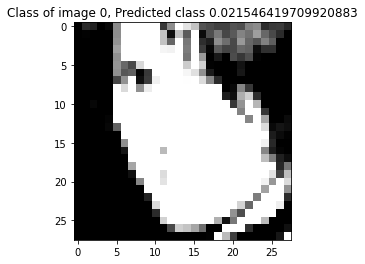

In [10]:
inputs, classes = next(iter(valDataLoader))
inputs = inputs.cuda()
output = model.predict(inputs)

inputs = inputs.cpu()
plt.imshow(inputs[0][0], cmap='gray', vmin=0, vmax=1)
plt.title('Class of image {}, Predicted class {}'.format(classes[0], output[0].item()))

In [11]:
def test(model, path):
    model = model.cuda()

    testTransforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    testDataLoader = getDataLoader(path, transforms=testTransforms, batch_size=32, shuffle=True)

    model.eval()
    testBatchAcc = 0
    numberOfImages = 0
    for inputs, classes in tqdm(testDataLoader):
            batchSize = inputs.shape[0]
            inputs = inputs.cuda()
            classes = classes.cuda()
            classes = classes.view(classes.shape[0], 1).to(torch.float32)
            outputs = model(inputs.to(torch.float32))
            results = torch.round(F.sigmoid(outputs))
            correct = (classes.eq(results.to(torch.float32))).sum()

            testBatchAcc += correct.item()
            numberOfImages += batchSize

    testBatchAcc = testBatchAcc / numberOfImages

    return testBatchAcc

print('Test Accuracy : {}'.format(test(model, './test')))

100%|██████████| 101/101 [00:00<00:00, 271.54it/s]Test Accuracy : 0.929368029739777

